In [1]:
import os
import keras as kr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow_hub as hub


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Extraccion de los datos 
****
El objetivo de este notebook es el analisis y creacion de un modelo que atravez de un tweet determine el valor o posible emergencia que pueda acontecer en el mesaje; donde predecira `1` en caso de que la emergencia sea real y `0` en el caso contrario

## Extraccion y primer contacto 
****
Ahora daremos un pequeño vistaso al data set y su contenido y definiremos cada columna

In [2]:
dataset = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_dataset = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [3]:
dataset.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


### Descripcion de columnas:
***
Como primera columna tenemos el `id` el cual hace referencia  a el numero correspondiente en la fila, para el analisis no ha de ser tan importante; `keword` son las palabras clave , `location` hace referencia a la ubicacion de donde procede el tweet, `text` el mensaje que he de analizar, `target` es el valor que hemos de esperar del modelo.

Como notaste en la grafica anterior hay datos incompletos hemos de analizar el numero maximo de ejemplos que tengamos y con base en ello determinar si es preferible predecir esas etiquetas vacias o por el contrario eliminar las filas (o columnas) enteras. 

In [4]:
dataset.shape

(7613, 5)

Veamos como se distribuyen los valores nulos.

In [5]:
valor_porcentual = dataset.isna().sum()/len(dataset)
pd.DataFrame([dataset.isna().sum(),valor_porcentual],index=['Cantidad de nulos','Peso porcentual'])

,id,keyword,location,text,target
Cantidad de nulos,0.0,61.000000,2533.00000,0.0,0.0
Peso porcentual,0.0,0.008013,0.33272,0.0,0.0


Como primera conclusion sabemos que los datos nulos equivalen a un `33%` por ende veremos como esto afecta a las predicciones o target.

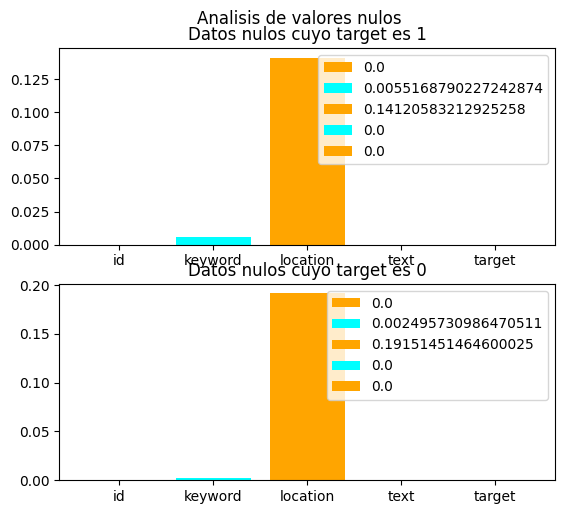

In [6]:
#creacion de filtros
target_correct=dataset.loc[:,:]['target'] == 1
target_incorrect=dataset.loc[:,:]['target'] != 1

#Aplicar filtro a los datos nulos
dataset_fil_correct_prob = dataset.loc[target_correct].isna().sum()/len(dataset)
dataset_fil_incorrect_prob = dataset.loc[target_incorrect].isna().sum()/len(dataset)


#Visualizacion de los datos
fig,ax = plt.subplots(2,1)
ax[0].bar(dataset_fil_correct_prob.keys(),dataset_fil_correct_prob.values,label=dataset_fil_correct_prob.values,color=['orange','cyan'])
ax[0].set_title("Datos nulos cuyo target es 1")
ax[0].legend()




ax[-1].bar(dataset_fil_incorrect_prob.keys(),dataset_fil_incorrect_prob.values,label=dataset_fil_incorrect_prob.values,color=['orange','cyan'])
ax[-1].legend()
ax[-1].set_title("Datos nulos cuyo target es 0")
fig.suptitle("Analisis de valores nulos")

#configuracion de espacios
plt.subplots_adjust(top=0.9,bottom=0.00001,wspace=0.1)


Como conslusion, podemos efectuar que al eliminar los datos nulos el target cuyas predicicones sea `1` contendra un `81%` de los datos restantes y el target cuyo valor sea `0` contendra el `86%` de los datos restantes   

In [7]:
dataset = dataset.dropna()
dataset.isna().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

## Analisis de los datos
***
Ahora procederemos a crear una breve analisis, donde concluyamos la importancia de las distintas columnas (principalmente `keyword` y `location`), para ello evaluaremos los valores unicos de cada columna con la vairanza presente en los datos.

Para ello evaluaremos la probabilidad de que el $target(T)=1$ dado una categoria de $keyword(K)=x_{n}$ o $location(L)=y_{n}$ y haremos el mismo analisis para el caso en que $target(T)=0$





#### Analisis `keyword`
***
Para este analisis evaluaremos las probabilidad general e individual donde evaluemos  que el valor del target sea 1 para cada columna

* Probabilidad de X dado un target

$P(X_{n} / T = 1) = X_{n}/X$ 

$P(X_{n} / T = 0) = X_{n}/X$ 


* Probabilidades de Target

$P(T = 1) = ∑_{n=X} P(X_{n}/T = 1) $


$P(T = 0) = ∑_{n=X} P(X_{n} /T = 0) $



In [8]:
def Probabilidades(column):
    #Categorizacion por target
    target_1 = dataset.loc[:,['target',column]].loc[dataset['target'] == 1]
    target_0 = dataset.loc[:,['target',column]].loc[dataset['target'] == 0]

    #Conteo de elementos existentes categorizados por los elementos unicos de la columna
    valores_unicos_target_0=target_0.groupby(column).count()
    valores_unicos_target_1=target_1.groupby(column).count()

    #Recopilazcion de los datos y creacion de dataset
    cuadro_comparativa = pd.DataFrame([valores_unicos_target_0['target'],valores_unicos_target_1['target']],index=['target = 0','target = 1']).fillna(0).T.sort_values('target = 0',ascending=False)
    cuadro_comparativa["N totales"]=cuadro_comparativa.iloc[:].apply(np.sum,axis=1)

    #definir funcion probabilisticas
    P = lambda x: x/cuadro_comparativa['N totales'].sum()
    
    
    #Creando las probabilidades
    cuadro_comparativa['P(X/T = 0)'] = [P(x) for x in cuadro_comparativa['target = 0'] ] 
    cuadro_comparativa['P(X/T = 1)'] = [P(x) for x in cuadro_comparativa['target = 1'] ] 
    cuadro_comparativa['P(X)'] = [P(x) for x in cuadro_comparativa['N totales']] 
    
    #Sacando el peso del target 1 y el target 0
    prob_general = [cuadro_comparativa['P(X/T = 0)'].sum(),cuadro_comparativa['P(X/T = 1)'].sum()]
    prob_general = pd.DataFrame(prob_general,index=['P(T=0)','P(T=1)'],columns=['Probabilidades']).T
    
    return cuadro_comparativa,prob_general

In [9]:
cuadro,prob_general=Probabilidades('keyword')
cuadro

,target = 0,target = 1,N totales,P(X/T = 0),P(X/T = 1),P(X)
keyword,,,,,,
armageddon,28.0,4.0,32.0,0.005512,0.000787,0.006299
ruin,27.0,1.0,28.0,0.005315,0.000197,0.005512
harm,26.0,4.0,30.0,0.005118,0.000787,0.005906
fear,25.0,3.0,28.0,0.004921,0.000591,0.005512
screaming,25.0,1.0,26.0,0.004921,0.000197,0.005118
...,...,...,...,...,...,...
derailment,0.0,25.0,25.0,0.000000,0.004921,0.004921
oil%20spill,0.0,27.0,27.0,0.000000,0.005315,0.005315
suicide%20bomber,0.0,11.0,11.0,0.000000,0.002165,0.002165


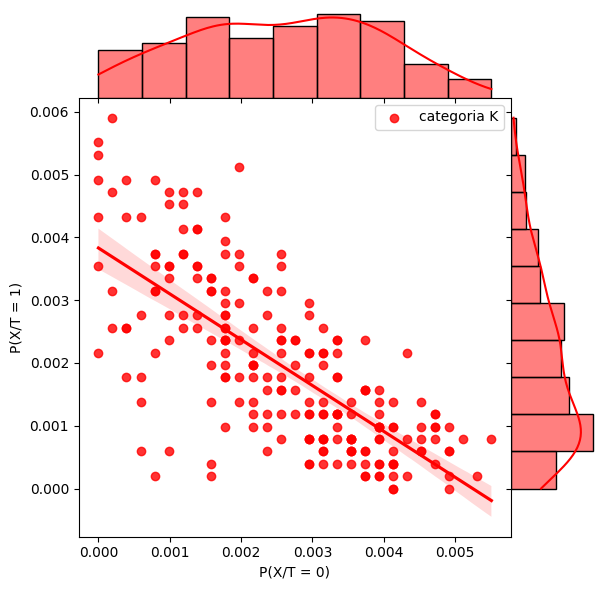

In [10]:
sns.jointplot(cuadro,x="P(X/T = 0)",y="P(X/T = 1)",space=0,kind="reg",color='red',label="categoria K")
plt.legend()

Como conlcusion de la figura anterior encontramos que la mayoria de categorias de `keyword` son inutiles, dado que muchas de ellas tienen un aproximdado de 10 aciertos por tweet, no obstante, aquellas `keywords` cuyo target es alto suele rebasar demaciado aquellos tweets falsos.


In [11]:
prob_general

,P(T=0),P(T=1)
Probabilidades,0.567717,0.432283


Como segunda conclusion sacamos el promedio de los target presentes en las 221 categorias del `keyword` donde encontramos que  cada categoria tiene aproximadamente un `56%` de todos los datos de tweet falsos, mientras que solo el `43%` de los tweets correctos se distribuyen en todas las categorias del `keyword`

/tmp/ipykernel_26/1750882127.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot([[cuadro['P(X)'][x],x] for x in range(len(cuadro))],color='salmon',ax=ax[0])


Text(0.5, 1.0, 'Analisis keyword')

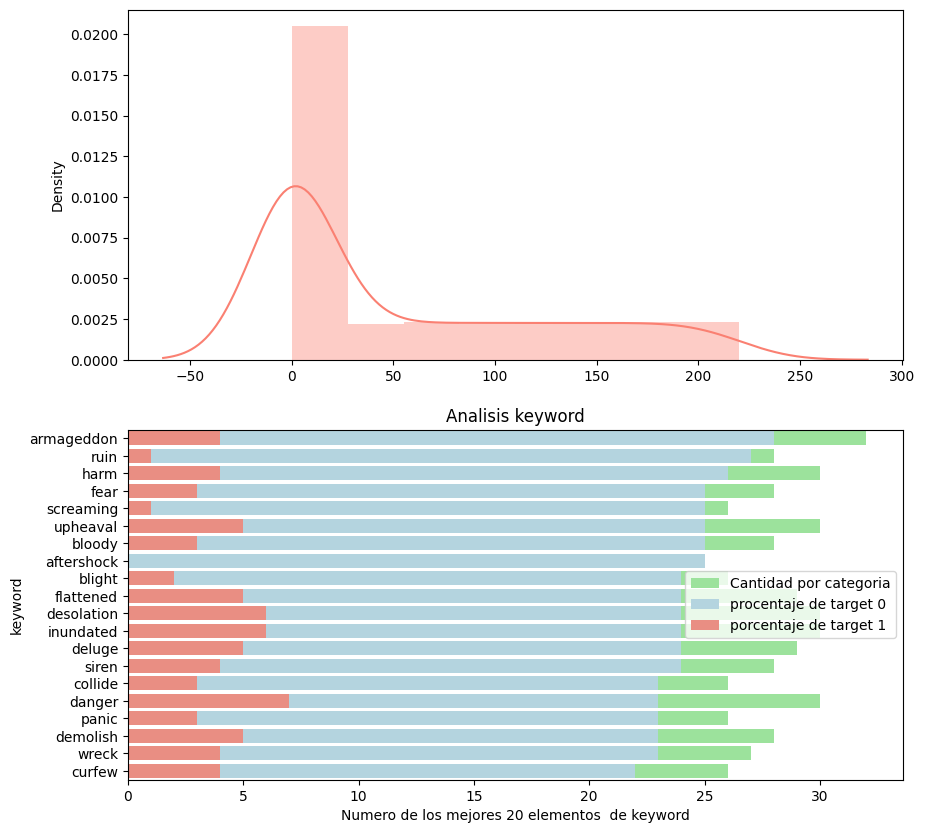

In [12]:
fig,ax=plt.subplots(2,1,figsize=(10,10))

#Heatmap de los datos
sns.distplot([[cuadro['P(X)'][x],x] for x in range(len(cuadro))],color='salmon',ax=ax[0])



sns.barplot(y=cuadro['target = 0'].keys()[:20],x=cuadro['N totales'][:20],color='lightgreen',label='Cantidad por categoria',ax=ax[-1])
sns.barplot(y=cuadro['target = 0'].keys()[:20],x=cuadro['P(X/T = 0)'][:20]*len(dataset),color='lightblue',label='procentaje de target 0',ax=ax[-1])
sns.barplot(y=cuadro['target = 0'].keys()[:20],x=cuadro['P(X/T = 1)'][:20]*len(dataset),color='salmon',label='porcentaje de target 1',ax=ax[-1])
ax[-1].legend()
plt.xlabel("Numero de los mejores 20 elementos  de keyword")
plt.title("Analisis keyword")


In [13]:
print(f'los primeros 50 datos: {cuadro["P(X)"][:50].sum()}')
print(f'los ultimos 50 datos: {cuadro["P(X)"][-50:].sum()}')

los primeros 50 datos: 0.2533464566929134
los ultimos 50 datos: 0.20905511811023625


Como ultimo analisis del *keyword* veremos como se distribuyen probabilistica de los distitos datos, donde encontramos que las primeras *50* categorias son de mucha importancia representando `25%` de lo datos totales; esto es importante por que  nos permite tomar estas etiquetas para el modelo y usar las otras bajo el nombre de "other" o algo similar, lo que ayudara al modelo a la hora de su entrenamiento.

#### Analisis `location`


In [14]:
cuadro,prob_general=Probabilidades('location')
cuadro.head()

,target = 0,target = 1,N totales,P(X/T = 0),P(X/T = 1),P(X)
location,,,,,,
New York,55.0,16.0,71.0,0.010827,0.003150,0.013976
USA,37.0,67.0,104.0,0.007283,0.013189,0.020472
London,29.0,16.0,45.0,0.005709,0.003150,0.008858
United States,23.0,27.0,50.0,0.004528,0.005315,0.009843
"Los Angeles, CA",18.0,8.0,26.0,0.003543,0.001575,0.005118


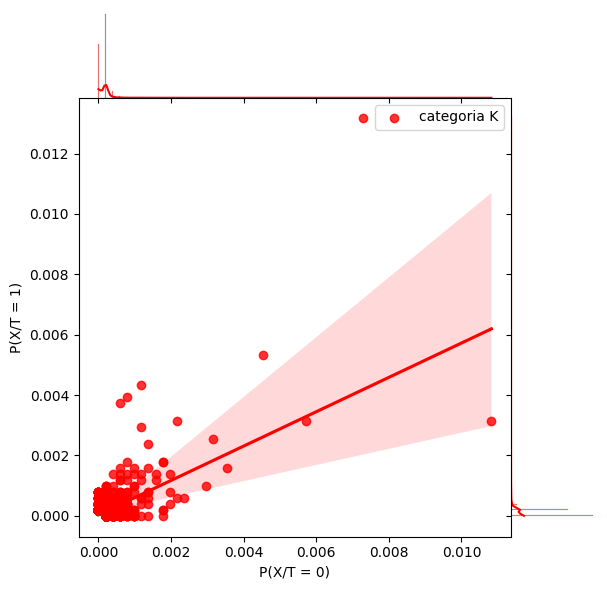

In [15]:
sns.jointplot(cuadro,x="P(X/T = 0)",y="P(X/T = 1)",space=0,kind="reg",color='red',label="categoria K")
plt.legend()



Como conclusion de la grafica, encontramos que gran parte de las categorias de `location` son datos unicos que por mucho tiene  o uno a diez datos dividios es las categorias, donde es mas probable que los datos esten 

In [16]:
prob_general

,P(T=0),P(T=1)
Probabilidades,0.567717,0.432283


Como segunda conclusion sacamos el promedio de los target presentes en las 221 categorias del `location` donde encontramos que  cada categoria tiene aproximadamente un `56%` de todos los datos de tweet falsos, mientras que solo el `43%` de los tweets correctos se distribuyen en todas las categorias del `location`

/tmp/ipykernel_26/3776234551.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot([[cuadro['P(X)'][x],x] for x in range(len(cuadro))],color='salmon',ax=ax[0])


Text(0.5, 1.0, 'Analisis keyword')

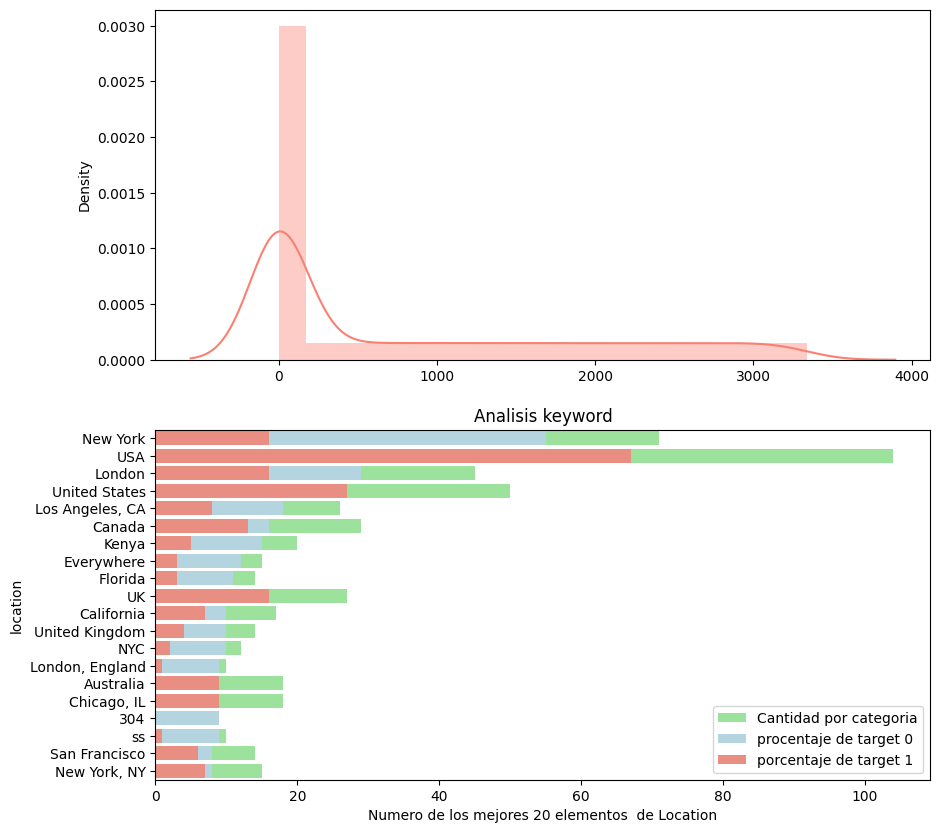

In [17]:
fig,ax=plt.subplots(2,1,figsize=(10,10))

#Heatmap de los datos
sns.distplot([[cuadro['P(X)'][x],x] for x in range(len(cuadro))],color='salmon',ax=ax[0])



sns.barplot(y=cuadro['target = 0'].keys()[:20],x=cuadro['N totales'][:20],color='lightgreen',label='Cantidad por categoria',ax=ax[-1])
sns.barplot(y=cuadro['target = 0'].keys()[:20],x=cuadro['P(X/T = 0)'][:20]*len(dataset),color='lightblue',label='procentaje de target 0',ax=ax[-1])
sns.barplot(y=cuadro['target = 0'].keys()[:20],x=cuadro['P(X/T = 1)'][:20]*len(dataset),color='salmon',label='porcentaje de target 1',ax=ax[-1])
ax[-1].legend()
plt.xlabel("Numero de los mejores 20 elementos  de Location")
plt.title("Analisis keyword")


In [18]:
print(f'los primeros 200 datos: {cuadro["P(X)"][:200].sum()}')
print(f'los ultimos 200 datos: {cuadro["P(X)"][-200:].sum()}')

los primeros 200 datos: 0.28641732283464566
los ultimos 200 datos: 0.04448818897637795


Como ultimo analisis del *location* veremos como se distribuyen probabilistica de los distitos datos, donde encontramos que las primeras *200* categorias son de mucha importancia representando `28%` de lo datos totales; esto es importante por que  nos permite tomar estas etiquetas para el modelo y usar las otras bajo el nombre de "other" o algo similar, lo que ayudara al modelo a la hora de su entrenamiento.

#### Conclusion General:
****
Como conclusion diriamos que escogeremos los primeros *50* categorias de `keyword` y  para  la columna de `location`  consideramos  que las *200* etiquetas sigue siendo muchas, por ende eliminaremos la columna.

In [19]:
del(prob_general)
del(cuadro)

In [20]:
#Extraccion nuevamente del dataset
cuadro,prob_general=Probabilidades('keyword')

#palabras clave
keyword = enumerate(dict(cuadro["P(X)"][:-50]).keys())
keyword =[x[-1]  for x in list(keyword)]


In [21]:
func = lambda x: 'another' if keyword.__contains__(x) else x
dataset['keyword'] = dataset['keyword'].apply(func)
len(dataset['keyword'].unique())

51

In [22]:
dataset.groupby('keyword')['text'].count().sort_values()/len(dataset)

keyword
inundation               0.000984
radiation%20emergency    0.001181
detonation               0.001575
razed                    0.001969
bioterrorism             0.002165
suicide%20bomber         0.002165
forest%20fire            0.002362
bombing                  0.002756
terrorism                0.002953
nuclear%20disaster       0.002953
forest%20fires           0.002953
bush%20fires             0.003346
rescuers                 0.003346
volcano                  0.003346
suicide%20bombing        0.003543
survivors                0.003740
fire%20truck             0.003740
massacre                 0.003937
terrorist                0.003937
wildfire                 0.003937
bridge%20collapse        0.003937
hostages                 0.004331
debris                   0.004331
famine                   0.004331
wild%20fires             0.004528
violent%20storm          0.004528
thunderstorm             0.004528
heat%20wave              0.004528
floods                   0.004724
suicid

In [23]:
# Eliminar la tabla de location
dataset.drop(['location','id'],inplace=True,axis=1)
dataset

,keyword,text,target
31,another,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,another,We always try to bring the heavy. #metal #RT h...,0
33,another,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,another,Crying out for more! Set me ablaze,0
35,another,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...
7575,another,On the bright side I wrecked http://t.co/uEa0t...,0
7577,another,@widda16 ... He's gone. You can relax. I thoug...,0
7579,another,Three days off from work and they've pretty mu...,0
7580,another,#FX #forex #trading Cramer: Iger's 3 words tha...,0


## Preparacion de los datos para el modelo
****
Ahora procederemos  dividir los datos, crear un *one hot encoding* , para ello hemos de visualizar en los texto los datos mas relevantes y eliminar caracteres especiales asi como urls

In [24]:
from sklearn.model_selection import train_test_split


### Eliminacion de caracteres especiales y urls
****

In [25]:
def Cleaning_text(text):
    text_split = text.split()    
    exception = ['@','#',"$",'%','^','*','(',')',':','.']

    for ids in range(30):
        try:
            #Detectar url
            if text_split[ids].__contains__('http'):
                text_split[ids] = ''

            #Deteccion de exception
            for exc in exception:
                if text_split[ids].__contains__(exc):
                    text_split[ids] = text_split[ids].replace(exc,'')
        except:
            text_split += '%'
                
    
    text_result = ' '.join(text_split)
    return text_result
        
    

In [26]:
dataset['text']=dataset['text'].apply(Cleaning_text)

### One hot encoding
****

In [27]:
def One_hot_encoding(text_data,numeros_type=False):
    #variables
    dicc = {}
    count = 0
    #funcion de reconocimiento de datos
    for text in text_data:
        for text_split in text.split():
            if not dicc.__contains__(text_split):
                dicc.setdefault(text_split.lower(),count) #Colocaremos todas las palabras en minusculas
                count += 1
                
    cantidad_total = list(dicc.values())[-1]
    #EXtraccion momentanea
    if numeros_type ==True:
        return dicc
    
    #Ceacion del one_hot_encoding
    for key in dicc.keys():
        zeros_list = np.zeros(cantidad_total+1)
        if key != "%":
            zeros_list[dicc[key]] = 1
        dicc[key] = zeros_list
        
        
    #Crear traduccion
    for text in text_data:
        for key in dicc.keys():
            if text.__contains__(key):
                mapa=np.zeros(30)
            
        
    return dicc
    
#diccionario_texto=One_hot_encoding(dataset['text'],True)
#diccionario_keyword=One_hot_encoding(dataset['keyword'],True)


In [28]:
diccionario_texto=One_hot_encoding(dataset['text'],True)
diccionario_keyword=One_hot_encoding(dataset['keyword'],True)

### Division de los datos
***

In [29]:
muestra = dataset.iloc[:int(len(dataset)*0.8)]

In [30]:
def keyword_func(index):
    zeros = np.zeros(len(diccionario_keyword))
    zeros[index] = 1
    return zeros

In [31]:
muestra['keyword']=muestra['keyword'].apply(lambda x: keyword_func(diccionario_keyword[x]))

/tmp/ipykernel_26/2751944590.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muestra['keyword']=muestra['keyword'].apply(lambda x: keyword_func(diccionario_keyword[x]))


In [32]:
def Traductor_lista(text,index_help=False):
    result=[]
    text_ = text.split()
    for x in range(30):
        try:
            if index_help ==True:
                print(f' encontrado: {text_[x]}')

            result +=[diccionario_texto[text_[x].lower()]]
        except:
            result+=[diccionario_texto['%']]
    return result

In [33]:
muestra['text_code']=muestra['text'].apply(lambda text: Traductor_lista(text))

/tmp/ipykernel_26/2038506177.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muestra['text_code']=muestra['text'].apply(lambda text: Traductor_lista(text))


<BarContainer object of 4064 artists>

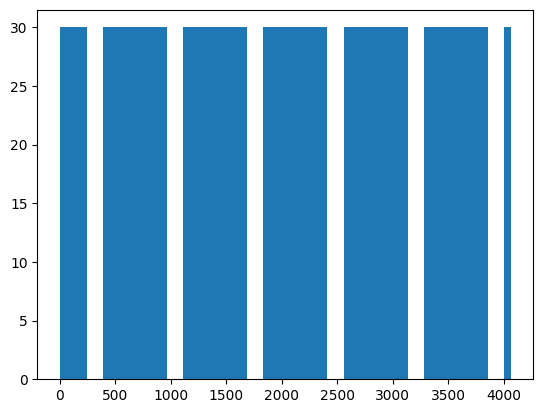

In [34]:
plt.bar(range(len(muestra['text'])),muestra['text_code'].apply(lambda x: len(x)))

In [35]:
muestra[['keyword','text','text_code']]

,keyword,text,text_code
31,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",bbcmtd Wholesale Markets ablaze % % % % % % %...,"[0, 1, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
32,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",We always try to bring the heavy metal RT % %...,"[5, 6, 7, 8, 9, 10, 11, 12, 13, 4, 4, 4, 4, 4,..."
33,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",AFRICANBAZE Breaking newsNigeria flag set abla...,"[14, 15, 16, 17, 18, 3, 19, 20, 4, 4, 4, 4, 4,..."
34,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Crying out for more! Set me ablaze % % % % % %...,"[21, 22, 23, 24, 18, 26, 3, 4, 4, 4, 4, 4, 4, ..."
35,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,"[27, 28, 29, 30, 31, 10, 33, 34, 35, 36, 37, 3..."
...,...,...,...
6030,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[Report 5] 182245 Ibaraki Prefecture offing M5...,"[25998, 25999, 26000, 26001, 26002, 26003, 260..."
6033,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Oil and Gas Exploration Takes Seismic Shift in...,"[7792, 79, 7384, 25967, 7130, 13802, 2453, 19,..."
6034,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",kakajambori ?? U control the future of india Y...,"[26019, 87, 2232, 2039, 10, 3318, 85, 2475, 26..."
6036,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Agency seeks comments on seismic permits % % ...,"[26027, 26028, 5212, 27, 13802, 9631, 4, 4, 4,..."


In [36]:
x_train,x_test,y_train,y_test = train_test_split(np.array(muestra['text_code']),np.array(muestra['target']),random_state=24)
x_train_key,x_test_key,y_train,y_test = train_test_split(np.array(muestra['keyword']),np.array(muestra['target']),random_state=24)

## Creacion y entrenamineto del modelo
****
Ahora procederemos a crear y entrenar el modelo

In [37]:
import keras as kr
from keras.regularizers import L1,L2

In [38]:
x_train_key = np.array([x for x in x_train_key])
x_train = np.array([x for x in x_train])

In [39]:
x_test_key = np.array([x for x in x_test_key])
x_test = np.array([x for x in x_test])

## `tipo uno del modelo`

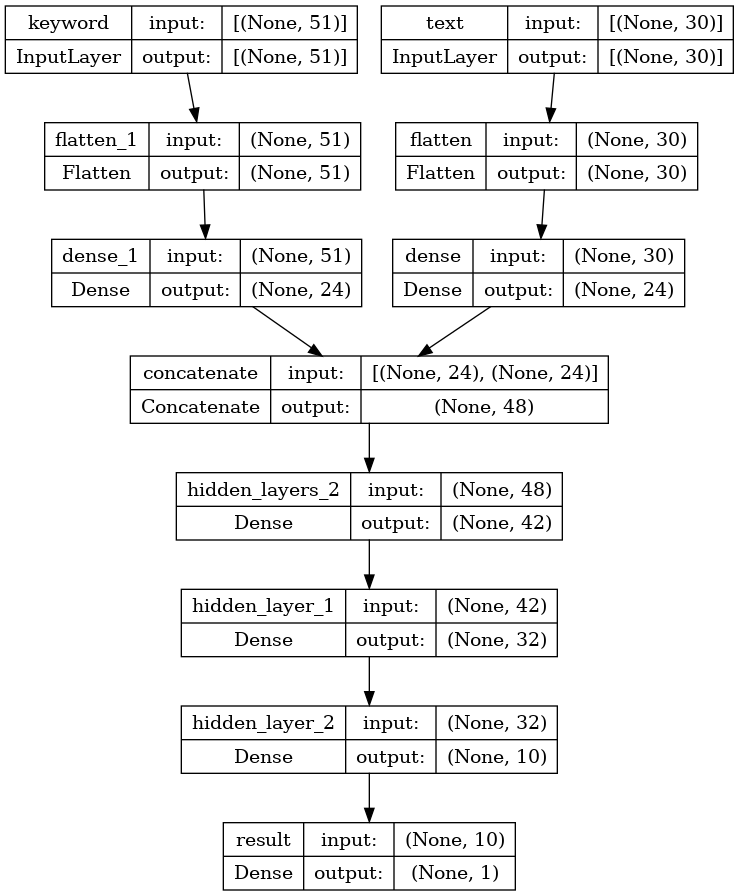

In [40]:
input_layer_keyword = kr.layers.Input(shape=(51,),name="keyword") #Datos con la logngitud del One hot encoding del kyword
input_layer_text = kr.layers.Input(shape=(30,),name="text")


#Tratamiendo de text
# kr.layers.Flatten
dense_text =kr.layers.Flatten()(input_layer_text)
dense_text = kr.layers.Dense(24,activation="sigmoid")(dense_text)

#Tratamiento de keyword
desne_keyword =kr.layers.Flatten()(input_layer_keyword)
desne_keyword = kr.layers.Dense(24,activation="sigmoid")(desne_keyword)

#Hidden layers
averge = kr.layers.concatenate([desne_keyword,dense_text])
sigmoid_layer = kr.layers.Dense(42,activation='relu',name='hidden_layers_2')(averge)
hidden = kr.layers.Dense(32,activation='relu',name='hidden_layer_1')(sigmoid_layer)
hidden = kr.layers.Dense(10,activation='relu',name='hidden_layer_2')(hidden)

#Resultado
result = kr.layers.Dense(1,activation='sigmoid',name='result')(hidden)


model = kr.Model([input_layer_keyword,input_layer_text],result)
model.compile('adam',loss='binary_crossentropy',metrics='acc')

#Mostrar el modelo
kr.utils.plot_model(model,show_shapes=True)


## `Segunda arquitectura`

### Entrenamiento del modelo

In [41]:
model.fit([x_train_key,x_train],y_train,epochs=5)

Epoch 1/5
96/96 [==============================] - 4s 4ms/step - loss: 0.6823 - acc: 0.5676
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.6718 - acc: 0.5860
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.6559 - acc: 0.6319
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.6273 - acc: 0.6690
Epoch 5/5
96/96 [==============================] - 0s 4ms/step - loss: 0.6084 - acc: 0.6811


### Testeo del modelo

In [42]:
model.evaluate([x_test_key,x_test],y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.6238 - acc: 0.6575


[0.6237616539001465, 0.6574802994728088]

32/32 [==============================] - 0s 2ms/step


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


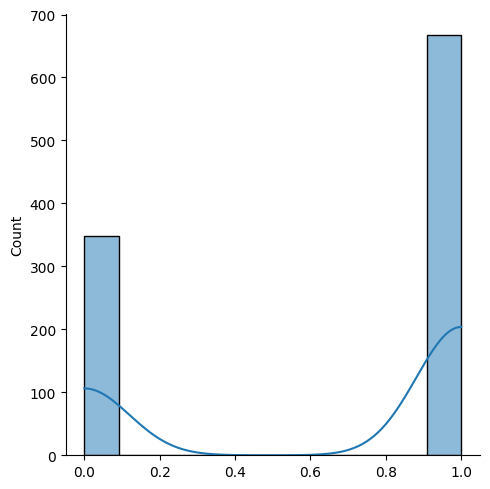

In [43]:
y_pred=model.predict([x_test_key,x_test])
y_pred = np.array([np.where(x <= 0.5,0,1) for x in y_pred]).reshape(len(y_pred))

# Grafica de rendimiento
analisis_aciertos=np.array([np.where(y_pred[x] == y_test[x],1,0) for x in range(len(y_pred))])
sns.displot(analisis_aciertos,kde=True)


### Pruebalo

In [44]:
#Extraccion del contnido del tweet
texto_prueba = "In Texas the largest forest reserve is burning, someone quickly call the fire department"
texto_prueba_bin=np.array(Traductor_lista(texto_prueba.lower(),True))

 encontrado: in
 encontrado: texas
 encontrado: the
 encontrado: largest
 encontrado: forest
 encontrado: reserve
 encontrado: is
 encontrado: burning,
 encontrado: someone
 encontrado: quickly
 encontrado: call
 encontrado: the
 encontrado: fire
 encontrado: department


In [45]:
#Hastag
key_prueba=diccionario_keyword['forest%20fires']

In [46]:
#Verificacion de exitencia del hastag en el modelo
[(np.where(x.__contains__('fire'),x,None)) for x in diccionario_keyword.keys()]

[array(None, dtype=object),
 array(None, dtype=object),
 array(None, dtype=object),
 array(None, dtype=object),
 array(None, dtype=object),
 array(None, dtype=object),
 array(None, dtype=object),
 array('buildings%20on%20fire', dtype=object),
 array('bush%20fires', dtype=object),
 array(None, dtype=object),
 array(None, dtype=object),
 array(None, dtype=object),
 array(None, dtype=object),
 array(None, dtype=object),
 array(None, dtype=object),
 array(None, dtype=object),
 array(None, dtype=object),
 array(None, dtype=object),
 array('fire%20truck', dtype=object),
 array(None, dtype=object),
 array(None, dtype=object),
 array('forest%20fire', dtype=object),
 array('forest%20fires', dtype=object),
 array(None, dtype=object),
 array(None, dtype=object),
 array(None, dtype=object),
 array(None, dtype=object),
 array(None, dtype=object),
 array(None, dtype=object),
 array(None, dtype=object),
 array(None, dtype=object),
 array(None, dtype=object),
 array(None, dtype=object),
 array(None, d

In [47]:
y_texto_predict = model.predict([np.array([keyword_func(key_prueba)]),np.array([texto_prueba_bin])])
y_texto_predict

def Deterinar_target(target):
    if target[0][0] >= .6:
        return 'es una emergencia real'
    else:
        return 'es una emergencia falsa'
Deterinar_target(y_texto_predict)

1/1 [==============================] - 0s 37ms/step


'es una emergencia real'

## Guardar el modelo

In [48]:
model.save('emergency_model_75.h5')